In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# adding imutils to our virtual environment
#import sys
#sys.path.append('../input/imutils-054/imutils-0.5.4')
root_path ='/content/drive/MyDrive/Colab Notebooks/dlcnn'

In [ ]:
import imutils
import os
import cv2
import datetime
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer

import pickle

In [ ]:
data = []
labels = []
imagePaths = []

# 📖 Load dataset (images, classes)


In [ ]:
images_path = "/content/drive/MyDrive/Colab Notebooks/dlcnn"

In [ ]:
classes = ["Motorbikes", "airplanes", "Faces"]

In [ ]:
# counts number of images in each class
def classes_counter(labels, class_name):
    counter = 0
    for l in labels:
        if l == class_name:
            counter += 1
    return counter

In [ ]:
for cl in classes:
    images_list = []

    path_new = images_path + "/" + cl + "/"
    print(path_new)

    # get the list of the available images
    for image in os.listdir(path_new):
        # get only images that
        # are located in folder
        if (image.endswith(".jpg")):
            images_list.append(image)

    # sort image_path in ascending order
    images_list = sorted(images_list)

    # loop over the images
    for img in images_list:
        label = cl

        image_path = os.path.sep.join([images_path, cl, img])
        image = cv2.imread(image_path)
        (h, w) = image.shape[:2]

        # load the image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)

        data.append(image)
        labels.append(label)
        imagePaths.append(image_path)

/content/drive/MyDrive/Colab Notebooks/dlcnn/Motorbikes/
/content/drive/MyDrive/Colab Notebooks/dlcnn/airplanes/
/content/drive/MyDrive/Colab Notebooks/dlcnn/Faces/


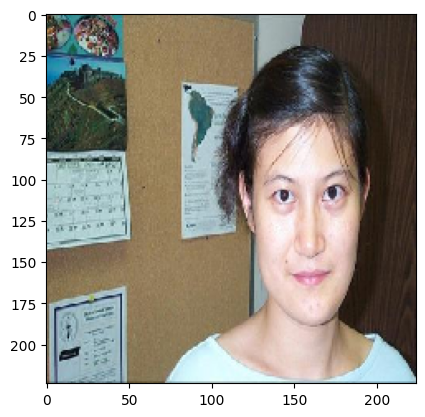

In [ ]:
# show the output image
imgplot = plt.imshow(image.astype('uint8'))
plt.show()

# 🔧 Data preparation

Let's check **how many images** are in each class.

In [ ]:
counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_face = classes_counter(labels, "Faces")

counter_mtb, counter_arp, counter_face

(798, 800, 435)

Here we get the **maximum value** of number of images.

In [ ]:
max_number = max(counter_mtb, counter_arp, counter_face)

As we can see, we don't have so much shooners, so we **need to augment** them. Also, I think, we'll create two more pictures of motorbikes in order to have also 800 pics. We'll do **scaling and rotating**.

In [ ]:
def make_scale(img):
    # scale range
    scale_val = random.uniform(0.8, 1.2)
    imgScaled = cv2.resize(img.copy(),
                           None,
                           fx=scale_val,
                           fy=scale_val)

    return imgScaled

In [ ]:
def make_rotate(img):
    (h, w) = img.shape[:2]

    # degrees range
    rotate_val = random.uniform(-5, 5)

    # image center
    center = (w / 2, h / 2)

    # Rotation Matrix
    M = cv2.getRotationMatrix2D(center,
                                rotate_val,
                                scale=1)

    imgRotated = cv2.warpAffine(img.copy(),
                                M,
                                (w, h))
    return imgRotated

equalize number of images
[**augmentation**](https://neptune.ai/blog/data-augmentation-in-python).

In [ ]:
def augment_data(counter, max_number, class_name):

    # while we don't have a lot of images
    while counter < max_number:
        # loop through each image in list

        for img in data:
            # check the number of images again

            if counter < max_number:
                # make scaling
                imgAug = img.copy()
                imgAug = make_scale(imgAug)

                # temporary save the new image
                cv2.imwrite("imgAug.jpg", imgAug)

                # load the new image
                imgAug = load_img("imgAug.jpg", target_size=(224, 224))
                imgAug = img_to_array(imgAug)

                # delete it from memory
                os.remove("imgAug.jpg")

                # add new image, it's label and path
                data.append(imgAug)
                labels.append(class_name)
                imagePaths.append(image_path)

                # recalculate a counter
                counter = classes_counter(labels, class_name)
            else:
                break

            # make rotating
            if counter < max_number:
                imgAug = img.copy()
                imgAug = make_rotate(imgAug)

                # temporary save the new image
                cv2.imwrite("imgAug.jpg", imgAug)

                # load the new image
                imgAug = load_img("imgAug.jpg", target_size=(224, 224))
                imgAug = img_to_array(imgAug)

                # delete it from memory
                os.remove("imgAug.jpg")

                # add new image and it's label and path
                data.append(imgAug)
                labels.append(class_name)
                imagePaths.append(image_path)

                # recalculate a counter
                counter = classes_counter(labels, class_name)
            else:
                break

Apply augmentation to **"Motorbikes" and "Faces"** classes.

In [ ]:
augment_data(counter_mtb, max_number, "Motorbikes")
augment_data(counter_face, max_number, "Faces")

**how many images** are in each class after augmentation.

In [ ]:
counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_face = classes_counter(labels, "Faces")

counter_mtb, counter_arp, counter_face

(800, 800, 800)

In [ ]:
# convert from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0

In [ ]:
# convert to numpy array
labels = np.array(labels)
imagePaths = np.array(imagePaths)

In [ ]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)

Here we **divide data to train and test sets**. I decided to divide into 95% to 5% respectively.

In [ ]:
split = train_test_split(data,
                         labels,
                         imagePaths,
                         test_size=0.05,
                         random_state=42)

And **unpack** *split* variable to different variables.

In [ ]:
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainPaths, testPaths) = split[4:]

Also, we can **save names of test images** in a * *.txt file* in order to test neural network later.

In [ ]:
f = open("testing_multiclass.txt", "w")
f.write("\n".join(testPaths))
f.close()

# 🧠 Neural Network Architecture
Here we'll use VGG16 neural network.

In [ ]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# freeze all layers of VGG
# in order not to train them
vgg.trainable = False

In [ ]:
# flatten the max-pooling
# output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

And for **class prediction (classification task)** we'll use a softmax [**activation function**](https://en.wikipedia.org/wiki/Softmax_function).

In [ ]:
# construct a second fully-connected
# layer header to predict
# the class label

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)

softmaxHead = Dense(len(lb.classes_),
                    activation="softmax",
                    name="class_label")(softmaxHead)

Finally, we need to **add this output** to our VGG16 model.

In [ ]:
model = Model(
    inputs=vgg.input,
    outputs=(softmaxHead))

Also, we need to define some **hyperparameters** *(learning rate, number of epochs, size of batch)*.

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 40
BATCH_SIZE = 32

Then we define a dictionary to set the **loss method**: *categorical crossentropy* for the class label.

In [ ]:
losses = {
    "class_label": "categorical_crossentropy",
}

Dictionary for **target training output**.

In [ ]:
trainTargets = {
    "class_label": trainLabels,
}

Second dictionary for **target testing output**.

In [ ]:
testTargets = {
    "class_label": testLabels,
}

**save only the best model** from all epochs:

In [ ]:
model_path = "model.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


 **initialize the optimizer, compile the model, and show the model summary**.

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(INIT_LR)

model.compile(loss=losses,
              optimizer=opt,
              metrics=["accuracy"])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#  Train Neural Network & Save best model
**train VGG16 network**

In [ ]:
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7939

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 31s 230ms/step - loss: 0.4719 - accuracy: 0.7939 - val_loss: 0.1472 - val_accuracy: 0.9417
Epoch 2/40
72/72 [==============================] - 11s 148ms/step - loss: 0.2767 - accuracy: 0.8807 - val_loss: 0.1200 - val_accuracy: 0.9500
Epoch 3/40
72/72 [==============================] - 10s 144ms/step - loss: 0.2259 - accuracy: 0.9035 - val_loss: 0.0936 - val_accuracy: 0.9750
Epoch 4/40
72/72 [==============================] - 10s 139ms/step - loss: 0.1941 - accuracy: 0.9175 - val_loss: 0.0924 - val_accuracy: 0.9583
Epoch 5/40
72/72 [==============================] - 10s 139ms/step - loss: 0.1616 - accuracy: 0.9355 - val_loss: 0.1091 - val_accuracy: 0.9333
Epoch 6/40
72/72 [==============================] - 10s 137ms/step - loss: 0.1504 - accuracy: 0.9360 - val_loss: 0.0945 - val_accuracy: 0.9667
Epoch 7/40
72/72 [==============================] - 10s 134ms/step - loss: 0.1214 - accuracy: 0.9469 - val_loss: 0.0998 - val_accuracy: 0.9583
Epoch 8/40

# 💾 Save label binarizer

In [ ]:
f = open("lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

# 📊 Visualize the results
**loss and accuracy**.

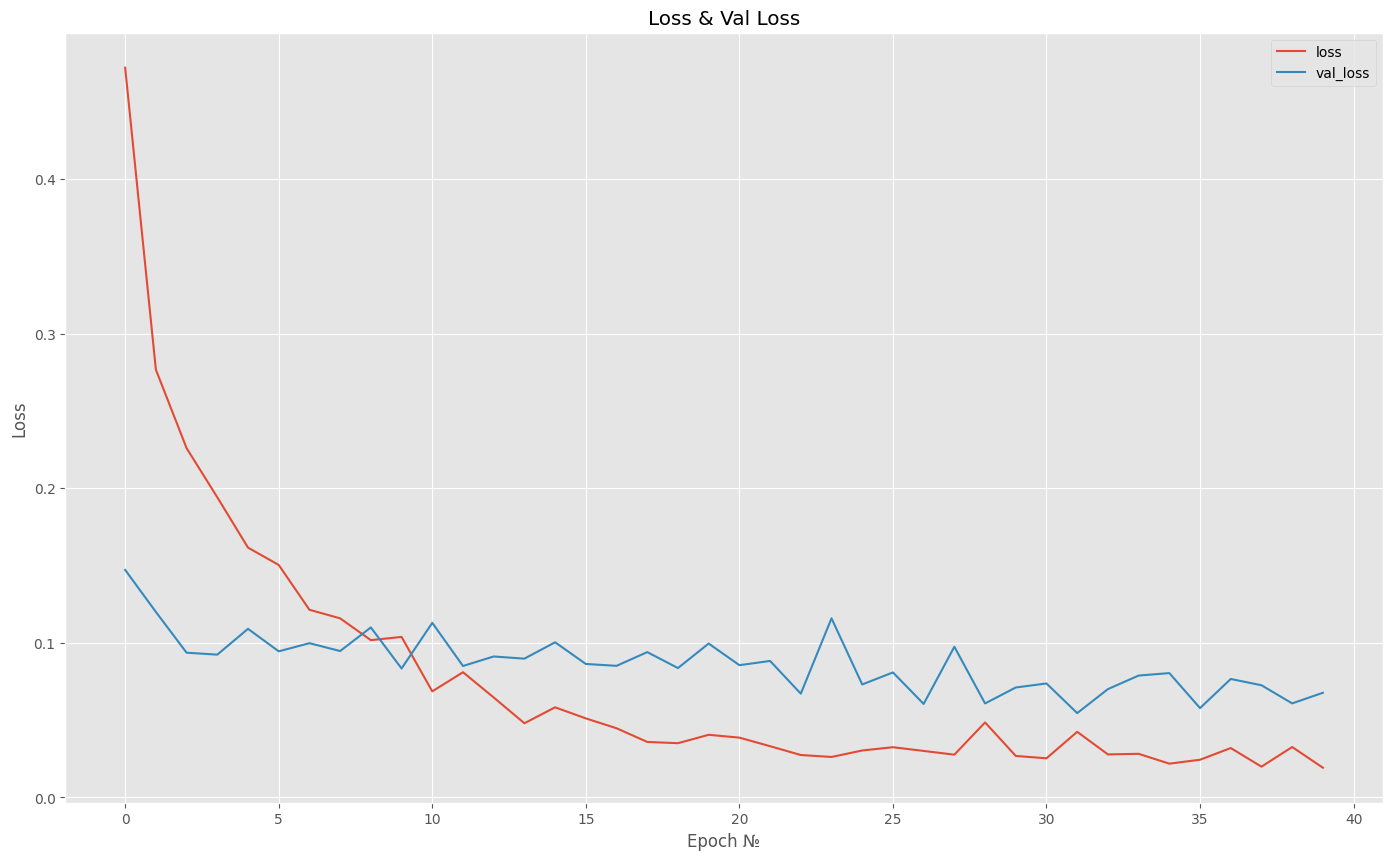

In [ ]:
import numpy as  np
lossNames = ["loss"]

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))


# plot the loss for both the training and validation data
plt.title("Loss & Val Loss")
plt.xlabel("Epoch №")
plt.ylabel("Loss")
plt.plot(N, H.history["loss"], label="loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

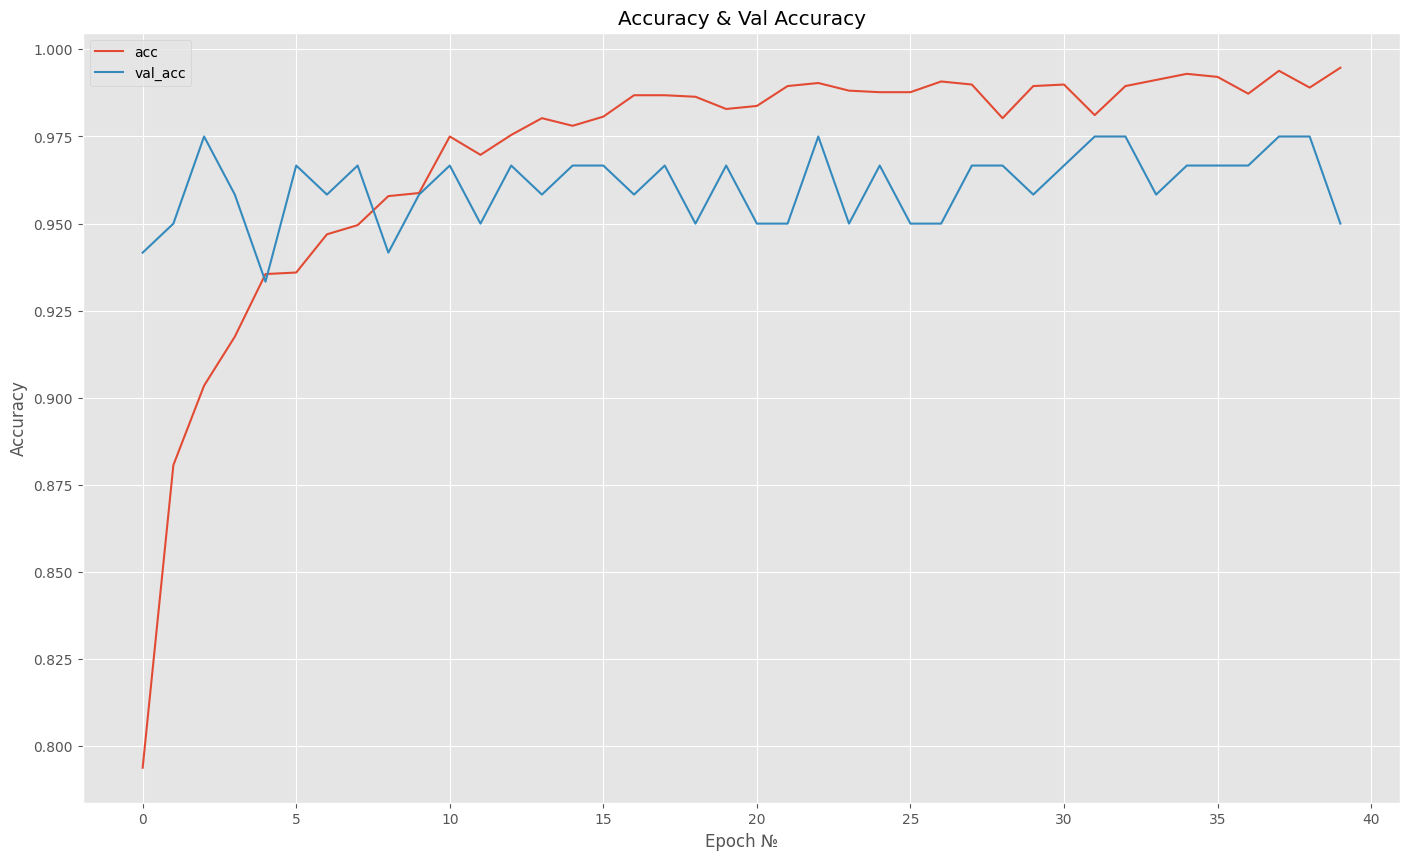

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))

plt.plot(N, H.history["accuracy"], label="acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")

plt.title("Accuracy & Val Accuracy")
plt.xlabel("Epoch №")
plt.ylabel("Accuracy")
plt.legend()

# 📋 Test the model
**filenames of test images**.

In [ ]:
path = "testing_multiclass.txt"
filenames = open(path).read().strip().split("\n")
imagePaths = []

for f in filenames:
    imagePaths.append(f)

**VGG16 model and label binarizer**.

In [ ]:
model = load_model("./model.h5")

In [ ]:
lb = pickle.loads(open("./lb.pickle", "rb").read())

**Predicting class of test images**.

1/1 [==============================] - 1s 800ms/step
class label =  Faces


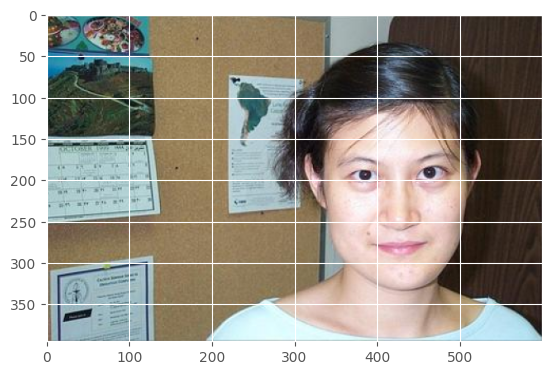

1/1 [==============================] - 0s 23ms/step
class label =  Faces


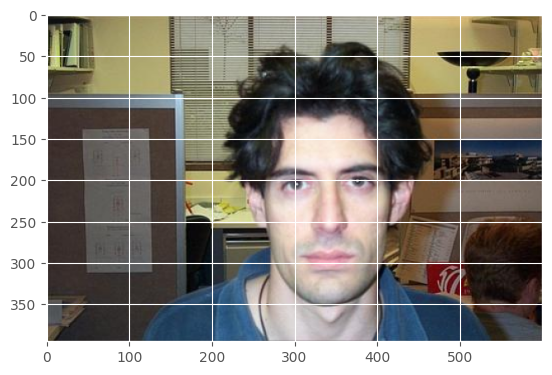

1/1 [==============================] - 0s 25ms/step
class label =  airplanes


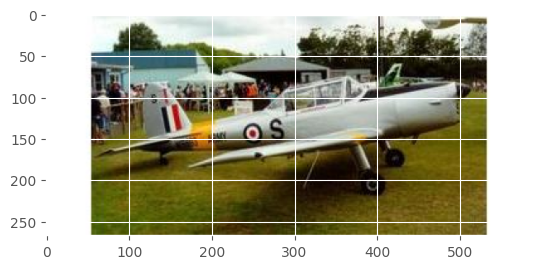

1/1 [==============================] - 0s 22ms/step
class label =  Faces


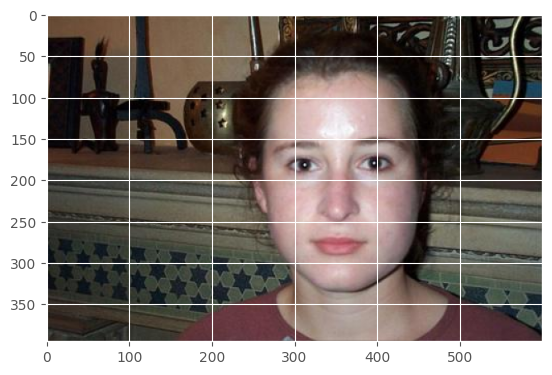

1/1 [==============================] - 0s 27ms/step
class label =  Faces


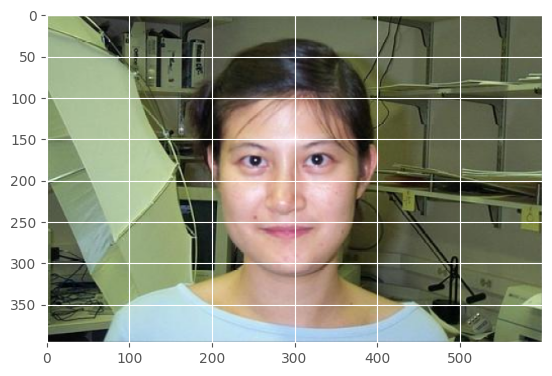

1/1 [==============================] - 0s 23ms/step
class label =  Motorbikes


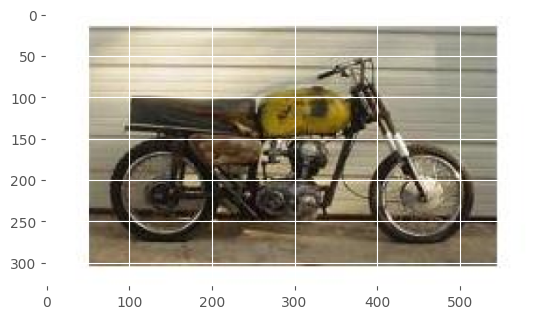

1/1 [==============================] - 0s 21ms/step
class label =  airplanes


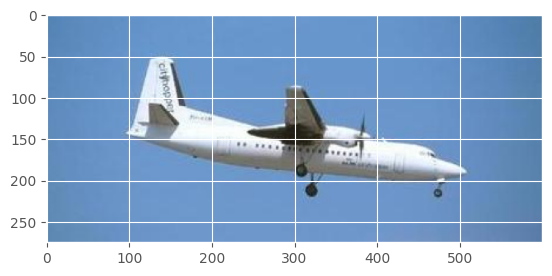

1/1 [==============================] - 0s 20ms/step
class label =  Faces


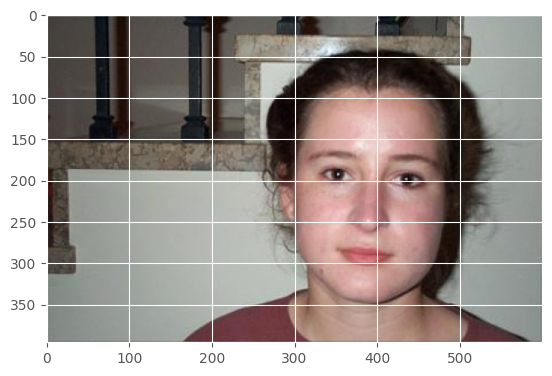

1/1 [==============================] - 0s 26ms/step
class label =  airplanes


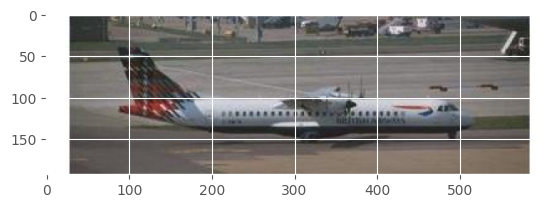

1/1 [==============================] - 0s 22ms/step
class label =  airplanes


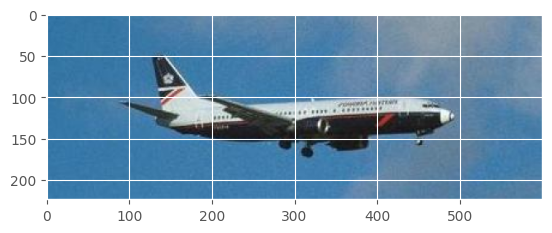

1/1 [==============================] - 0s 23ms/step
class label =  Faces


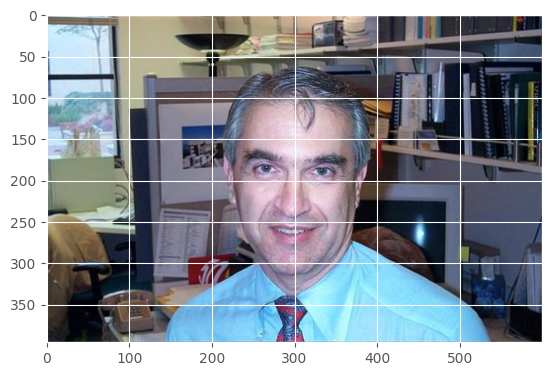

In [ ]:
# counter for viewing images
cntr = 0

for imagePath in imagePaths:

    # load the input image
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # predict classes
    (labelPreds) = model.predict(image)

    # determine the class label
    # with the largest predicted
    # probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # load the input image (in OpenCV format)
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]



    # show the output image
    print("class label = ", label)
    imgplot = plt.imshow(cv2.cvtColor(image,
                                      cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.show()

    # increment counter
    cntr += 1

    # view only first 10
    # test images
    if (cntr > 10):
        break